In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna # 하이퍼파라미터 튜닝 라이브러리
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Optuna
하이퍼파라미터 최적화 태스크를 도와주는 프레임워크로 파라미터 범위나 목록을 설정하면 매 trial마다 파라미터를 변경하며 최적 파라미터를 찾습니다.

In [ ]:
df = pd.read_csv("../input/30days-folds/train_folds.csv")
df_test = pd.read_csv("../input/30-days-of-ml/test.csv")
sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")

useful_features = [c for c in df.columns if c not in ("id", "target", "kfold")]
object_cols = [col for col in useful_features if col.startswith("cat")]
df_test = df_test[useful_features]

for col in object_cols:
    temp_df = []
    temp_test_feat = None
    for fold in range(5):
        xtrain =  df[df.kfold != fold].reset_index(drop=True)
        xvalid = df[df.kfold == fold].reset_index(drop=True)
        
        # 명목형 변수를 그냥 라벨 처리하기에는 한계가 있으므로 각 값 별로 타겟값의 평균을 대입해주고자 한다.
        # 이때 과적합을 막기위해 5-foldCV를 활용하여 각 폴드별 값의 평균을 대입해준다.
        feat = xtrain.groupby(col)["target"].agg("mean")
        feat = feat.to_dict()
        xvalid.loc[:, f"tar_enc_{col}"] = xvalid[col].map(feat)
        temp_df.append(xvalid)
        if temp_test_feat is None:
            temp_test_feat = df_test[col].map(feat)
        else:
            temp_test_feat += df_test[col].map(feat)
    
    temp_test_feat /= 5
    df_test.loc[:, f"tar_enc_{col}"] = temp_test_feat
    df = pd.concat(temp_df)
    

useful_features = [c for c in df.columns if c not in ("id", "target", "kfold")]
object_cols = [col for col in useful_features if col.startswith("cat")]
df_test = df_test[useful_features]

In [ ]:
def run(trial):
    # 구하고자하는 변수들의 범위 설정
    fold = 0
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 10)

    xtrain = df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)

    ytrain = xtrain.target
    yvalid = xvalid.target

    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    
    # 앞에서 명목형 변수들에 대하여 새로운 변수를 만들었으므로 기존 변수는 라벨인코딩하여 적용
    ordinal_encoder = preprocessing.OrdinalEncoder()
    xtrain[object_cols] = ordinal_encoder.fit_transform(xtrain[object_cols])
    xvalid[object_cols] = ordinal_encoder.transform(xvalid[object_cols])

    model = XGBRegressor(
        random_state=42,
        # XGB GPU활용 파라미터
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_estimators=7000,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )
    model.fit(xtrain, ytrain, early_stopping_rounds=300, eval_set=[(xvalid, yvalid)], verbose=1000)
    preds_valid = model.predict(xvalid)
    rmse = mean_squared_error(yvalid, preds_valid, squared=False) # 평가지표 설정
    return rmse

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(run, n_trials=20)

In [ ]:
# 최종 하이퍼파라미터
study.best_params

In [ ]:
X = df.drop(['target', 'kfold', 'id'], axis=1)
y = df.target

In [ ]:
ordinal_encoder = preprocessing.OrdinalEncoder()
X[object_cols] = ordinal_encoder.fit_transform(X[object_cols])

In [ ]:
para = study.best_params

model = XGBRegressor(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_jobs=-1,
        n_estimators=7000,
        ** para
    )


cross_val_score(model, X, y, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1).mean()

optuna를 그냥 쓰면 여러 모델을 병렬적으로 쓰는 기능밖에 제시를 안 한다.
따라서 여러가지 옵션을 사용하여 파라미터를 찾아보자

## TPESampler
TPE(Tree-structured Parzen Estimator) 알고리즘을 사용하는 샘플러.
https://optuna.readthedocs.io/en/stable/reference/samplers.html

In [ ]:
from optuna import Trial
from optuna.samplers import *

study = optuna.create_study(direction="minimize", sampler=TPESampler())
study.optimize(run, n_trials=20)

In [ ]:
# 최종 하이퍼파라미터
study.best_params

In [ ]:
para = study.best_params

model = XGBRegressor(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_jobs=-1,
        n_estimators=7000,
        ** para
    )

cross_val_score(model, X, y, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1).mean()

## SkoptSampler
Scikit-Optimize를 백엔드로 사용하는 샘플러.
https://optuna.readthedocs.io/en/stable/reference/integration.html

In [ ]:
from optuna.integration import SkoptSampler

study = optuna.create_study(direction="minimize", sampler=SkoptSampler())
study.optimize(run, n_trials=20)

In [ ]:
study.best_params

In [ ]:
para = study.best_params

model = XGBRegressor(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_jobs=-1,
        n_estimators=7000,
        ** para
    )

cross_val_score(model, X, y, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1).mean()

조금의 차이긴 하지만 같은 횟수 내 SkoptSampler의 경우에 가장 좋은 파라미터를 찾아냈다.

    
SkoptSampler의 파라미터를 조정하여 다시 모델의 하이퍼파라미터를 찾아본다



Gaussian Process에서 다음 파라미터를 추천하는 함수를 Acquisition Function이라고 하는데, 여기선 Expected Improvement(EI)를 사용하여 파라미터를 찾는다. EI는 exploration 전략 및 exploitation 전략 모두를 내재적으로 일정 수준 포함하도록 설계된 것으로, Acquisition Function으로 가장 많이 사용된다.

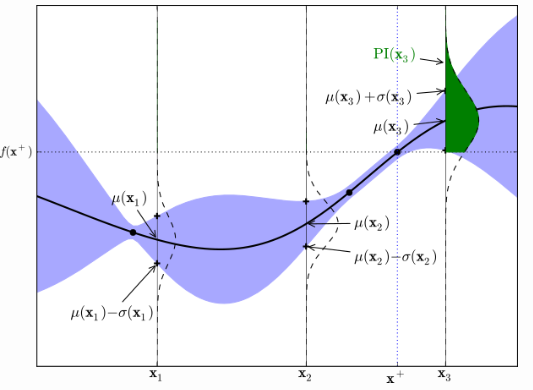

- Acquisiton Function : surrogate model이 목적함수 (우리가 찾고자 하는 함수)에 대하여 실제 데이터를 기반으로 다음 번 조사할 x 값을 확률적으로 계산하여 추천해주는 함수이다.
- Exploitation : 현재까지 조사된 값들의 근방으로 다시 조사를 하는 것이다. 착취를 말한다.
- Exploration : 현재까지 조사된 값들의 근방으로 조사를 하지 않고, 불확실성이 제일 높은 구간을 조사한다. 탐험을 말한다. 

In [ ]:
from optuna.integration import SkoptSampler

sampler=SkoptSampler(skopt_kwargs={'base_estimator':'RF', 'base_estimator':'ET', 'n_random_starts': 0, 'acq_func':'EI', 'acq_func_kwargs': {'xi':0.01}})

study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(run, n_trials=20)

In [ ]:
study.best_params

In [ ]:
para = study.best_params

model = XGBRegressor(
        random_state=42,
        tree_method="gpu_hist",
        gpu_id=1,
        predictor="gpu_predictor",
        n_jobs=-1,
        n_estimators=7000,
        ** para
    )

cross_val_score(model, X, y, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1).mean()

위의 파라미터를 설정한 경우 같은 횟수 내 좋은 파라미터를 찾지는 못했다. 하지만 횟수를 높인다면 다른 방법들 보다 더 빨리 좋은 성능의 모델을 찾을 수 있을 것이다.